In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, glob, string

from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18
from torchvision import transforms

from tqdm.notebook import tqdm
import multiprocessing as mp
import cv2 
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import string

In [2]:
BATCH_SIZE = 16
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-3
CLIP_NORM = 5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cpu_count = mp.cpu_count()

print(f'Device: {DEVICE}')
print(f'cpu_count: {cpu_count}')

Device: cuda
cpu_count: 16


### Dataset

In [ ]:
# def download_and_unzip(url, extract_to="Datasets"):
#     http_response = urlopen(url)
#     zipfile = ZipFile(BytesIO(http_response.read()))
#     zipfile.extractall(path=extract_to)
    
# if not os.path.exists(os.path.join("Datasets", "captcha_images_v2")):
#     download_and_unzip("https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip",
#                        extract_to="Datasets")

In [3]:
path = 'datasets/captcha_images_v2/'
images = os.listdir(path)

unique_len = np.unique([len(img.split(".")[0]) for img in images])

print(f'Total images: {len(images)}')
print(f'Unique length of capthca: {unique_len}')

Total images: 1040
Unique length of capthca: [5]


In [4]:
images[:10]

['7m8px.png',
 'e5n66.png',
 'y2xg4.png',
 'pcpg6.png',
 '3g2w6.png',
 'dn26n.png',
 'mcyfx.png',
 'mgdwb.png',
 '2wx73.png',
 'pgg3n.png']

In [5]:
#check for non-captcha if len of capthca not equal to 5
for idx, filename in enumerate(images):
    if len(filename.split(".")[0]) != 5:
        print(f'Found file "{filename}" at index {idx} that is non-captcha image')
        images.remove(filename) 

print(f'After cleaning, there are: {len(images)} images')

After cleaning, there are: 1040 images


### Character Mapping

In [6]:
# all_letters = string.ascii_lowercase + string.digits

# mapping = dict()
# mapping_inv = dict()
# i = 0
# for x in all_letters:
#     mapping[x] = i
#     mapping_inv[i] = x
#     i += 1
    
# num_chars = len(mapping)
# num_chars

In [7]:
all_filename = [filename.split('.')[0] for filename in images]
all_filename = ''.join(all_filename)
# print(list(all_filename))
all_letters = sorted(list(set(list(all_filename))))
print(all_letters)

vocab = ['-'] + all_letters
print(vocab)
print(len(vocab))

['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']
['-', '2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']
20


In [8]:
idx2char = {k:v for k, v in enumerate(vocab)}
print(idx2char)

char2idx = {v:k for k, v in idx2char.items()}
print(char2idx)

num_chars = len(idx2char)
print(num_chars)

{0: '-', 1: '2', 2: '3', 3: '4', 4: '5', 5: '6', 6: '7', 7: '8', 8: 'b', 9: 'c', 10: 'd', 11: 'e', 12: 'f', 13: 'g', 14: 'm', 15: 'n', 16: 'p', 17: 'w', 18: 'x', 19: 'y'}
{'-': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5, '7': 6, '8': 7, 'b': 8, 'c': 9, 'd': 10, 'e': 11, 'f': 12, 'g': 13, 'm': 14, 'n': 15, 'p': 16, 'w': 17, 'x': 18, 'y': 19}
20


### Split train and test

In [9]:
train_images, test_images = train_test_split(images, random_state=0)
print(f'Train images: {len(train_images)}')
print(f'Test images: {len(test_images)}')

Train images: 780
Test images: 260


### DataLoader

In [10]:
class CaptchaDataset(Dataset):
    def __init__(self, base_dir, image_filenames, transform):
        self.base_dir = base_dir
        self.image_filenames = image_filenames
        self.transform = transform
        
    def __len__(self,):
        return len(self.image_filenames)
    
    def __getitem__(self, idx):
        image_filename = self.image_filenames[idx]
        image_filepath = os.path.join(self.base_dir, image_filename)
        image = Image.open(image_filepath).convert('RGB')
        image = self.transform(image)
        label = image_filename.split('.')[0]
        
        return (image, label)
    
    
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    )
])

In [11]:
train_dataset = CaptchaDataset(path, train_images, transform)
test_dataset = CaptchaDataset(path, test_images, transform)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=cpu_count, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=cpu_count, shuffle=False)

print(f'{len(train_loader)} batches in the train_loader')
print(f'{len(test_loader)} batches in the test_loader')

49 batches in the train_loader
17 batches in the test_loader


In [13]:
image_batch, text_batch = next(iter(train_loader))

print(image_batch.size(), text_batch)

Traceback (most recent call last):
  File "/home/oliver/miniconda3/envs/cuda/lib/python3.11/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/oliver/miniconda3/envs/cuda/lib/python3.11/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/oliver/miniconda3/envs/cuda/lib/python3.11/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/home/oliver/miniconda3/envs/cuda/lib/python3.11/shutil.py", line 738, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/oliver/miniconda3/envs/cuda/lib/python3.11/shutil.py", line 736, in rmtree
    os.rmdir(path, dir_fd=dir_fd)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-g400x5cz'


torch.Size([16, 3, 50, 200]) ('53wb8', 'gd8fb', 'cpe63', 'm5meg', 'e2mg2', '56m6y', '7gce6', 'n3bm6', 'pnmxf', 'ffd6p', '5n245', 'mc35n', 'w2n7e', '8g4yp', 'wwmn6', '4egem')


### Model

In [14]:
resnet = resnet18(pretrained=True)
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/home/oliver/miniconda3/envs/cuda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/oliver/miniconda3/envs/cuda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
resnet_modules = list(resnet.children())[:-3]
print(resnet_modules)

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(inplace=True), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False), Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

In [16]:
class CRNN(nn.Module):
    def __init__(self, num_chars, hidden_size=256, dropout=0.1):
        super(CRNN, self).__init__()
        self.num_classes = num_chars
        self.hidden_size = hidden_size
        self.dropout = dropout
        
        
        # CNN #1 --> Get resnet18 without the last 3 layer
        resnet_modules = list(resnet.children())[:-3]
        self.cnn_backbone = nn.Sequential(*resnet_modules)
        
        # CNN #2 --> Add custom layers
        self.cnn_custom = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 6), stride=1, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True)
        )
        
        self.linear1 = nn.Linear(1024, 256)
        
        # RNN
        self.rnn1 = nn.GRU(input_size=self.hidden_size, hidden_size=self.hidden_size, bidirectional=True, batch_first=True)
        self.rnn2 = nn.GRU(input_size=self.hidden_size, hidden_size=self.hidden_size, bidirectional=True, batch_first=True)
        
        self.linear2 = nn.Linear(self.hidden_size*2, self.num_classes)
        
        
    def forward(self, batch):
        #  Pass through the first set of CNN layers (ResNet)
        x = self.cnn_backbone(batch) 
        # print(x.size()) # torch.Size([-1, 256, 4, 13])
        
        # Pass through the second set of custom CNN layers
        x = self.cnn_custom(x) # [batch_size, channels, height, width]
        # print(x.size())# torch.Size([-1, 256, 4, 10])
        
        x = x.permute(0, 3, 1, 2)  # Permute dimensions to [batch_size, width, channels, height]
        # print(x.size()) # torch.Size([-1, 10, 256, 4])
        
        batch_size, width, channels, height= x.size()
        x = x.view(batch_size, width, -1)  # Reshape to # [batch_size, width, num_features==channels*height]
        # print(x.size()) # torch.Size([-1, 10, 1024])
         
        x = self.linear1(x)  # Pass through the linear layer
        # print(x.size()) # torch.Size([-1, 10, 256])
        
        x, hidden = self.rnn1(x)  # Pass through the first bidirectional GRU layer
        feature_size = x.size(2)
        x = x[:, :, :feature_size // 2] + x[:, :, feature_size // 2:]  # Combine bidirectional outputs
        # print(x.size()) # torch.Size([-1, 10, 256])
        
        x, hidden = self.rnn2(x)  # Pass through the second bidirectional GRU layer
        # print(x.size()) # torch.Size([-1, 10, 512])
        
        x = self.linear2(x)  # Pass through the final linear layer
        # print(x.size()) # torch.Size([-1, 10, 20])
        
        x = x.permute(1, 0, 2)  # Permute dimensions back to [width, batch_size, num_classes==num_feature]
        # print(x.size()) # torch.Size([10, -1, 20])
        
        return x


In [17]:
# Create dummy input
dummy_input = torch.randn(16, 3, 50, 200) # [batch_size, channels, height, width]

# Create the model
model = CRNN(num_chars=num_chars)

# Forward pass
output = model(dummy_input)

# Print the output shape
print("Output shape:", output.shape)

Output shape: torch.Size([10, 16, 20])


In [18]:
print(model)
print(model.__class__.__name__)

CRNN(
  (cnn_backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [19]:
def initialize_weight(layer):
    """
    Initialize the weights of a neural network layer.

    Args:
        layer (torch.nn.Module): The layer to initialize.

    Returns:
        None
    """
    # Extract the class name of the layer
    class_name = layer.__class__.__name__

    if type(layer) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        # Xavier/Glorot initialization for Linear and Convolutional layers
        torch.nn.init.xavier_uniform_(layer.weight)
        
        if layer.bias is not None:
            # Set biases to a constant value (0.01)
            layer.bias.data.fill_(0.01)
    
    elif class_name.find('BatchNorm') != -1:
        # Normal initialization for BatchNorm layers
        layer.weight.data.normal_(1.0, 2.0)
        
        if layer.bias is not None:
            # Set biases to a constant value (0)
            layer.bias.data.fill_(0)


In [20]:
hidden_size = 256

crnn = CRNN(num_chars=num_chars, hidden_size=hidden_size)
crnn.apply(initialize_weight)
crnn.to(DEVICE)
print(crnn)

CRNN(
  (cnn_backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [21]:
text_batch_logits = crnn(image_batch.to(DEVICE))

print(text_batch)
print(text_batch_logits.shape)

('53wb8', 'gd8fb', 'cpe63', 'm5meg', 'e2mg2', '56m6y', '7gce6', 'n3bm6', 'pnmxf', 'ffd6p', '5n245', 'mc35n', 'w2n7e', '8g4yp', 'wwmn6', '4egem')
torch.Size([10, 16, 20])


### Loss Function

In [22]:
criterion = nn.CTCLoss(blank=0)

In [23]:
def encode_text_batch(text_batch):
    """
    Encode a list of string labels into a format suitable for training a neural network.

    Args:
        labels (list): List of string labels.
        mapping (dict): A dictionary mapping characters to numerical values.

    Returns:
        tuple: Tuple containing encoded targets (torch.Tensor) and lengths of each original label (torch.Tensor).
    """
    
    text_batch_targets_lens = [len(label) for label in text_batch] # Calculate the lengths of each label in the batch
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens) # Convert the list of lengths to a PyTorch IntTensor
    
    text_batch_concat = ''.join(text_batch) # Concatenate all labels into a single string
    
    text_batch_targets = [char2idx[char] for char in text_batch_concat] # Map characters to numerical values using the provided mapping
    text_batch_targets = torch.IntTensor(text_batch_targets)  # Convert the list of targets to a PyTorch IntTensor
    
    # Return a tuple containing the encoded targets and lengths
    return text_batch_targets, text_batch_targets_lens

print(text_batch)
encode_text_batch(text_batch)

('53wb8', 'gd8fb', 'cpe63', 'm5meg', 'e2mg2', '56m6y', '7gce6', 'n3bm6', 'pnmxf', 'ffd6p', '5n245', 'mc35n', 'w2n7e', '8g4yp', 'wwmn6', '4egem')


(tensor([ 4,  2, 17,  8,  7, 13, 10,  7, 12,  8,  9, 16, 11,  5,  2, 14,  4, 14,
         11, 13, 11,  1, 14, 13,  1,  4,  5, 14,  5, 19,  6, 13,  9, 11,  5, 15,
          2,  8, 14,  5, 16, 15, 14, 18, 12, 12, 12, 10,  5, 16,  4, 15,  1,  3,
          4, 14,  9,  2,  4, 15, 17,  1, 15,  6, 11,  7, 13,  3, 19, 16, 17, 17,
         14, 15,  5,  3, 11, 13, 11, 14], dtype=torch.int32),
 tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32))

In [24]:
def compute_loss(text_batch, text_batch_logits):
    """
    Compute the loss between predicted and ground truth sequences.

    Args:
        text_batch (list): List of strings of length equal to batch size
        text_bath_logits (torch.Tensor): Predicted logits from the model with Tensor of size ([T==width, batch_size, num_classes]).

    Returns:
        torch.Tensor: The computed loss.
    """
    # Apply log_softmax to the predicted logits
    text_batch_logps = F.log_softmax(text_batch_logits, 2) # [T==width, batch_size, num_classes]

    # Create a tensor for predicted label lengths
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),),
                                       fill_value=text_batch_logps.size(0),
                                       dtype=torch.int32).to(DEVICE)
    # print(text_batch_logps.shape)
    # print(text_batch_logps_lens)

    # Encode ground truth text batch and lengths using encode_text_batch function 
    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)

    # print(text_batch_targets)
    # print(text_batch_targets_lens)
    loss = criterion(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)

    return loss

    
compute_loss(text_batch, text_batch_logits)

tensor(4.4116, device='cuda:0', grad_fn=<MeanBackward0>)

### Train the model

In [25]:
optimizer = optim.Adam(crnn.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=5)

In [27]:
train_losses = []
val_losses = []
train_epoch_losses = []
val_epoch_lossses = []
total_train_steps = 0
total_val_steps = 0

for epoch in tqdm(range(1, NUM_EPOCHS + 1)):
    train_steps = 0
    val_steps = 0
    train_epoch_loss = 0
    val_epoch_loss = 0
    
    crnn.train()
    for image_batch, text_batch in tqdm(train_loader, leave=False):
        optimizer.zero_grad()
        text_batch_logits = crnn(image_batch.to(DEVICE))
        loss = compute_loss(text_batch, text_batch_logits) # calculate loss
        batch_loss = loss.item()
        
        if np.isnan(batch_loss) or np.isinf(batch_loss):
            continue

        train_steps += 1
        train_epoch_loss += batch_loss
        train_losses.append(batch_loss)
        loss.backward() # make backward
        nn.utils.clip_grad_norm_(crnn.parameters(), CLIP_NORM)
        optimizer.step()

    train_loss = train_epoch_loss / len(train_loader)
    print(f'Epoch: {epoch}  Train_loss: {train_loss}  Num_updates: {train_steps}')
    
    with torch.no_grad():
        crnn.eval()
        for val_image_batch, val_text_batch in test_loader:
            val_text_batch_logits = crnn(val_image_batch.to(DEVICE)) # [T, batch_size, num_classes==num_features]
            val_loss = compute_loss(val_text_batch,  val_text_batch_logits)
            val_epoch_loss += val_loss.item()
            val_steps += 1
            val_losses.append(val_loss.item())
            
    val_loss = val_epoch_loss / len(test_loader)
    print(f'Epoch: {epoch}  Val_loss: {val_loss}  Num_updates: {val_steps}')
    
    train_epoch_losses.append(train_loss)
    val_epoch_lossses.append(val_loss)

    lr_scheduler.step(val_losses[-1])
    total_train_steps += train_steps
    total_val_steps += val_steps

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch: 1  Train_loss: 2.868611204380892  Num_updates: 49
Epoch: 1  Val_loss: 3.0508061717538273  Num_updates: 17


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch: 2  Train_loss: 2.2427782963733285  Num_updates: 49
Epoch: 2  Val_loss: 2.1165676958420696  Num_updates: 17


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch: 3  Train_loss: 1.8035190835291026  Num_updates: 49
Epoch: 3  Val_loss: 1.5381902386160458  Num_updates: 17


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch: 4  Train_loss: 1.2849395737356069  Num_updates: 49
Epoch: 4  Val_loss: 1.4072879833333634  Num_updates: 17


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch: 5  Train_loss: 0.8913900499441185  Num_updates: 49
Epoch: 5  Val_loss: 0.9184256686883814  Num_updates: 17


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch: 6  Train_loss: 0.5527751977954592  Num_updates: 49
Epoch: 6  Val_loss: 0.8000670829240013  Num_updates: 17


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch: 7  Train_loss: 0.4116643889217961  Num_updates: 49
Epoch: 7  Val_loss: 0.7495833179529976  Num_updates: 17


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch: 8  Train_loss: 0.3552744461565602  Num_updates: 49
Epoch: 8  Val_loss: 0.554112607941908  Num_updates: 17


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch: 9  Train_loss: 0.2988978717095998  Num_updates: 49
Epoch: 9  Val_loss: 0.7982030756333295  Num_updates: 17


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch: 10  Train_loss: 0.22714895770257834  Num_updates: 49
Epoch: 10  Val_loss: 0.42486923231798057  Num_updates: 17


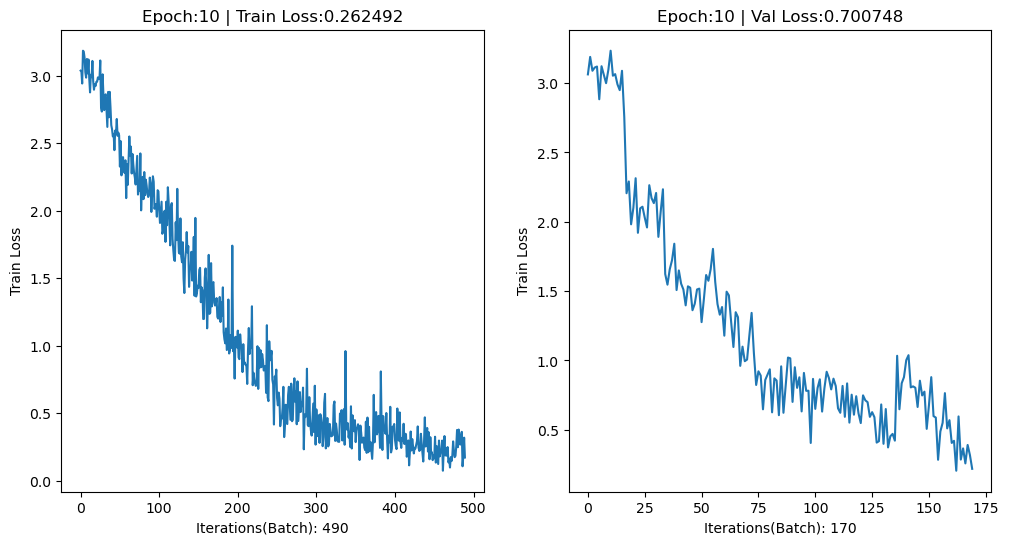

In [28]:
# making titles
n_steps = 100
train_title = f'Epoch:{epoch} | Train Loss:{np.mean(train_losses[-n_steps:]):.6f}'
val_title = f'Epoch:{epoch} | Val Loss:{np.mean(val_losses[-n_steps:]):.6f}'

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(train_losses)
ax[0].set_title(train_title)
ax[0].set_xlabel(f'Iterations(Batch): {total_train_steps}')
ax[0].set_ylabel('Train Loss')

ax[1].plot(val_losses)
ax[1].set_title(val_title)
ax[1].set_xlabel(f'Iterations(Batch): {total_val_steps}')
ax[1].set_ylabel('Train Loss')

plt.show()

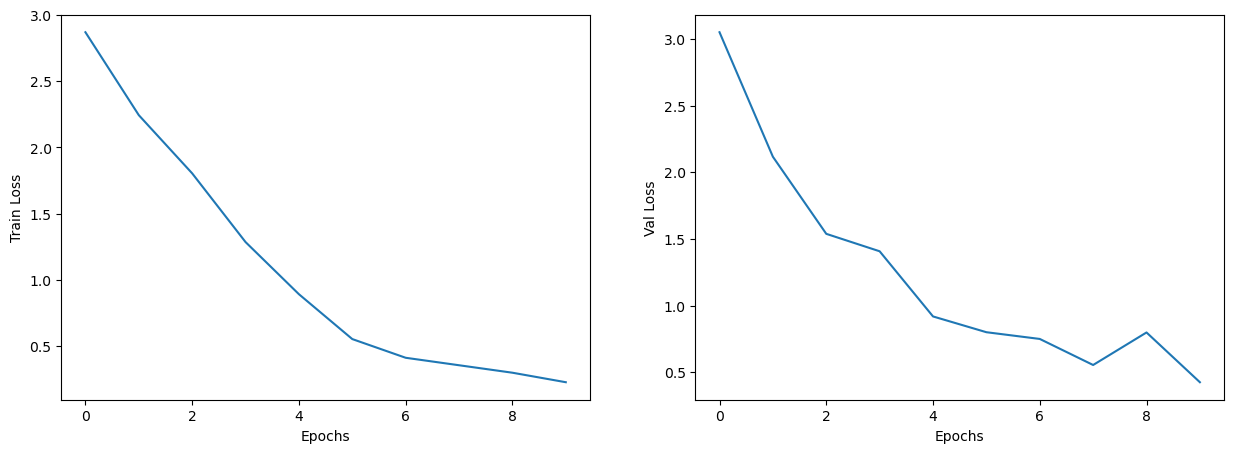

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_epoch_losses)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Train Loss')

ax2.plot(val_epoch_lossses)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Val Loss')

plt.show()

In [ ]:
# epoch_losses = []
# batch_losses = []
# total_steps = []

# for epoch in tqdm(range(1, NUM_EPOCHS + 1)):
#     epoch_loss_list = []
#     num_steps = 0

#     for image_batch, text_batch in tqdm(train_loader, leave=False):
#         optimizer.zero_grad()
#         text_batch_logits = crnn(image_batch.to(DEVICE))
#         loss = compute_loss(text_batch, text_batch_logits)
#         batch_loss = loss.item()

#         if np.isnan(batch_loss) or np.isinf(batch_loss):
#             continue

#         num_steps += 1
#         batch_losses.append(batch_loss)
#         epoch_loss_list.append(batch_loss)
#         loss.backward()
#         nn.utils.clip_grad_norm_(crnn.parameters(), CLIP_NORM)
#         optimizer.step()

#     epoch_loss = np.mean(epoch_loss_list)
#     print(f'Epoch: {epoch}  Loss: {epoch_loss}  Num_updates: {num_steps}')

#     epoch_losses.append(epoch_loss)
#     total_steps.append(num_steps)
#     lr_scheduler.step(epoch_loss)


# # Plot Losses
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# ax1.plot(epoch_losses)
# ax1.set_xlabel('Epochs')
# ax1.set_ylabel('Loss')

# ax2.plot(batch_losses)
# ax2.set_xlabel('Iterations(Batch)')
# ax2.set_ylabel('Loss')

# plt.show()

### Predictions

In [30]:
def decode_predictions(text_batch_logits):
    """
    Decode predicted text_batch_logits into human-readable format.

    Args:
        text_batch_logits (torch.Tensor): Predicted logits from the model.

    Returns:
        list: List of decoded tokens.
    """
    # Apply softmax and get the index of the maximum value along the third dimension
    text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []

    # Iterate over each token to reconstruct the captcha
    for text_token in text_batch_tokens:
        text = [idx2char[idx] for idx in text_token]
        text = ''.join(text)
        text_batch_tokens_new.append(text)
        
    return text_batch_tokens_new

In [ ]:
def decode_predictions_beam_search(text_batch_logits, idx2char, beam_width=5):
    """
    Decode predicted text_batch_logits into human-readable format using beam search.

    Args:
        text_batch_logits (torch.Tensor): Predicted logits from the model.
        idx2char (dict): A dictionary mapping token indices to corresponding characters.
        beam_width (int): Width of the beam for beam search.

    Returns:
        list: List of decoded tokens.
    """
    # Apply softmax to get probabilities
    text_batch_probs = F.softmax(text_batch_logits, 2)  # [T, batch_size, num_classes]

    # Initialize beams
    beams = [([], 0.0)] * beam_width

    # Iterate over each time step
    for t in range(text_batch_probs.size(0)):
        all_candidates = []

        # Iterate over each beam
        for beam in beams:
            prefix, score = beam

            # If the prefix is not empty, get the last token index
            if prefix:
                last_token = prefix[-1]
                last_token_prob = text_batch_probs[t, :, last_token].numpy()
                top_candidates = last_token_prob.argsort()[-beam_width:][::-1]
            else:
                # If the prefix is empty, consider top candidates for the first time step
                top_candidates = range(text_batch_probs.size(1))

            # Generate new candidates
            for candidate in top_candidates:
                candidate_prefix = prefix + [candidate]
                candidate_score = score + float(text_batch_probs[t, :, candidate].log().item())
                all_candidates.append((candidate_prefix, candidate_score))

        # Select top beams from all candidates
        beams = sorted(all_candidates, key=lambda x: x[1], reverse=True)[:beam_width]

    # Convert indices to characters
    decoded_texts = [''.join([idx2char[idx] for idx in beam[0]]) for beam in beams]

    return decoded_texts

# decoded_texts_beam_search = decode_predictions_beam_search(text_batch_logits, idx2char, beam_width=3)

In [31]:
# Create an empty DataFrame to store the results
results_train = pd.DataFrame(columns=['actual', 'prediction'])

# Use torch.no_grad() to disable gradient computation during inference
with torch.no_grad():
    # Iterate over the test loader
    for image_batch, text_batch in tqdm(train_loader, leave=True):
        # Forward pass to get predictions
        text_batch_logits = crnn(image_batch.to(DEVICE)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())  # Decode predicted labels
        # print(text_batch, text_batch_pred)
        
        # Create a DataFrame to store the current batch's results
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred

        # Concatenate the current batch's results to the overall results DataFrame
        results_train = pd.concat([results_train, df])

# Reset the index of the final results DataFrame
results_train = results_train.reset_index(drop=True)

  0%|          | 0/49 [00:00<?, ?it/s]

In [32]:
print(results_train.shape)
results_train.head()

(780, 2)


,actual,prediction
0,2nx38,2nx-3----8
1,mm3nn,m-n3n----n
2,cen55,ce-n5---55
3,m5meg,m5n-eg---g
4,d3c7y,d3cc7----y


In [33]:
# Create an empty DataFrame to store the results
results_test = pd.DataFrame(columns=['actual', 'prediction'])

# Use torch.no_grad() to disable gradient computation during inference
with torch.no_grad():
    # Iterate over the test loader
    for image_batch, text_batch in tqdm(test_loader, leave=True):
        # Forward pass to get predictions
        text_batch_logits = crnn(image_batch.to(DEVICE)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())  # Decode predicted labels
        # print(text_batch, text_batch_pred)
        
        # Create a DataFrame to store the current batch's results
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred

        # Concatenate the current batch's results to the overall results DataFrame
        results_test = pd.concat([results_test, df])

# Reset the index of the final results DataFrame
result_test = results_test.reset_index(drop=True)

  0%|          | 0/17 [00:00<?, ?it/s]

In [34]:
print(results_test.shape)
results_test.head()

(260, 2)


,actual,prediction
0,bny4w,bn-y4----w
1,dce8y,dc-e8----y
2,nn4wx,m-4-w----x
3,byc82,by-c8----2
4,5bb66,5bb-6----6


In [35]:
def remove_duplicates(text):
    """
    Remove consecutive duplicate characters from a given text.

    Args:
        text (str): Input text.

    Returns:
        str: Text with consecutive duplicate characters removed.
    """
    if len(text) > 1:
        # Keep the first occurrence and remove consecutive duplicates
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx - 1]]
    elif len(text) == 1:
        # For a single character, keep it
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)


def correct_prediction(word):
    """
    Correct a predicted word containing hyphens by removing consecutive duplicate characters.

    Args:
        word (str): Predicted word.

    Returns:
        str: Corrected word.
    """
    # Split the word by hyphens and remove consecutive duplicates in each part
    parts = word.split('-')
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = ''.join(parts)
    return corrected_word

In [36]:
results_train['prediction_corrected'] = results_train['prediction'].apply(correct_prediction)
results_train.head()

,actual,prediction,prediction_corrected
0,2nx38,2nx-3----8,2nx38
1,mm3nn,m-n3n----n,mn3nn
2,cen55,ce-n5---55,cen55
3,m5meg,m5n-eg---g,m5negg
4,d3c7y,d3cc7----y,d3c7y


In [37]:
results_test['prediction_corrected'] = results_test['prediction'].apply(correct_prediction)
results_test.head()

,actual,prediction,prediction_corrected
0,bny4w,bn-y4----w,bny4w
1,dce8y,dc-e8----y,dce8y
2,nn4wx,m-4-w----x,m4wx
3,byc82,by-c8----2,byc82
4,5bb66,5bb-6----6,5b66


In [49]:
test_dataset[0]

(tensor([[[1.1700, 1.1700, 1.1700,  ..., 2.1804, 2.1804, 2.1804],
          [1.1700, 1.1700, 1.1700,  ..., 2.1804, 2.1804, 2.1804],
          [1.1700, 1.1700, 1.1700,  ..., 2.1804, 2.1804, 2.1804],
          ...,
          [1.2214, 1.2214, 1.2214,  ..., 2.2318, 2.2318, 2.2318],
          [1.2214, 1.2214, 1.2214,  ..., 2.2318, 2.2318, 2.2318],
          [1.2214, 1.2214, 1.2214,  ..., 2.2318, 2.2318, 2.2318]],
 
         [[1.3256, 1.3256, 1.3256,  ..., 2.3585, 2.3585, 2.3585],
          [1.3256, 1.3256, 1.3256,  ..., 2.3585, 2.3585, 2.3585],
          [1.3256, 1.3256, 1.3256,  ..., 2.3585, 2.3585, 2.3585],
          ...,
          [1.3782, 1.3782, 1.3782,  ..., 2.4111, 2.4111, 2.4111],
          [1.3782, 1.3782, 1.3782,  ..., 2.4111, 2.4111, 2.4111],
          [1.3782, 1.3782, 1.3782,  ..., 2.4111, 2.4111, 2.4111]],
 
         [[1.5420, 1.5420, 1.5420,  ..., 2.5703, 2.5703, 2.5703],
          [1.5420, 1.5420, 1.5420,  ..., 2.5703, 2.5703, 2.5703],
          [1.5420, 1.5420, 1.5420,  ...,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


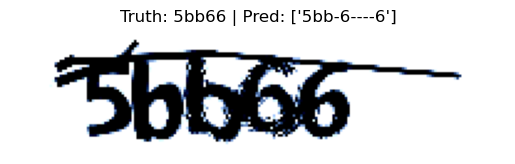

In [75]:
def print_prediction(model, dataset):
    idx = np.random.randint(len(dataset))
    
    with torch.no_grad():
        model.eval()
        img, target_text = dataset[idx]
        batch_img = img.unsqueeze(0)
        logits = model(batch_img.to(DEVICE))
        
    pred_text = decode_predictions(logits.cpu())
    img = img.permute(1, 2, 0) # channels last
    title = f'Truth: {target_text} | Pred: {pred_text}'
    plt.imshow(img)
    plt.title(title)
    plt.axis('off');
    
print_prediction(crnn, test_dataset)

### Evaluate the model

In [38]:
mistakes_df = results_test[results_test['actual'] != results_test['prediction_corrected']]
mistakes_df

,actual,prediction,prediction_corrected
2,nn4wx,m-4-w----x,m4wx
4,5bb66,5bb-6----6,5b66
5,662bw,66-2b----w,62bw
6,56c34,86c38----4,86c384
9,5mcy7,5nc-y----7,5ncy7
...,...,...,...
7,b3xpn,b3xxpn---n,b3xpnn
10,pf5ng,pf5nng---g,pf5ngg
14,ypw3d,yp-w3-----,ypw3
15,c3n8x,c3n------x,c3nx


In [39]:
print(mistakes_df['prediction_corrected'].str.len().value_counts())

prediction_corrected
4    51
5    44
6    19
3     4
7     1
Name: count, dtype: int64


In [40]:
mask = mistakes_df['prediction_corrected'].str.len() == 5
mistakes_df[mask]

,actual,prediction,prediction_corrected
9,5mcy7,5nc-y----7,5ncy7
10,cdcb3,ed-cb----3,edcb3
11,25egp,25e-p----y,25epy
13,n7enn,n7e-m----n,n7emn
2,p7fyp,p7-fp----p,p7fpp
12,wddcp,w-d-dcm---,wddcm
2,8ypdn,8y-pd----m,8ypdm
12,n4wwn,m4-m-wm---,m4mwm
3,bw5nf,b-w5m----f,bw5mf
6,7gnge,7gm-g----e,7gmge


datasets/captcha_images_v2/5mcy7.png


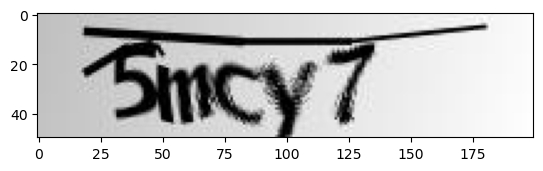

In [41]:
mistake_image_fp = os.path.join(path, mistakes_df[mask]['actual'].values[0] + ".png")
print(mistake_image_fp)
mistake_image = Image.open(mistake_image_fp)
plt.imshow(mistake_image)
plt.show()

In [42]:
train_accuracy = accuracy_score(results_train['actual'], results_train['prediction_corrected'])
print(train_accuracy)
test_accuracy = accuracy_score(results_test['actual'], results_test['prediction_corrected'])
print(test_accuracy)

0.7384615384615385
0.5423076923076923
